In [3]:
# 기본 라이브러리
import numpy as np
import pandas as pd

#저장라이브러리
import pickle

import gc

from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import SelectFromModel
from sklearn.metrics import classification_report
from sklearn.preprocessing import LabelEncoder

from xgboost import XGBClassifier
from sklearn.metrics import classification_report
from catboost import CatBoostClassifier
from collections import Counter

In [4]:
import matplotlib.pyplot as plt

# 그래프 기본 설정
plt.rcParams['figure.figsize'] = 12, 6
plt.rcParams['font.size'] = 14
plt.rcParams['axes.unicode_minus'] = False


import matplotlib as mpl
import matplotlib.font_manager as fm

# 폰트 파일 경로 지정
font_path = '/content/drive/MyDrive/Colab Notebooks/NanumGothic.ttf'

# 폰트 등록 및 matplotlib 설정
font_name = fm.FontProperties(fname=font_path).get_name()
fm.fontManager.addfont(font_path)
mpl.rc('font', family=font_name)

# 1. data load

In [25]:
train = pd.read_parquet('/content/drive/MyDrive/final_project/train_회원정보.parquet')

# 2. data split

In [7]:
# 타겟 변수 분리
X = train.drop('Segment', axis=1) # segment 뺀 컬럼들
y = train['Segment'] # segment만

# 샘플링(240만건은 너무 많 => 7월 40만)
X_sample = X.iloc[:400000]
y_sample = y.iloc[:400000]

# ID 제거
id_sample = X_sample['ID']
X_sample = X_sample.drop('ID', axis=1)

# train/val 분리
X_train, X_val, y_train, y_val = train_test_split(X_sample, y_sample, test_size=0.2, stratify=y_sample, random_state=40)

In [8]:
len(X_train), len(X_val)

(320000, 80000)

# 3. select feature

- catboost

In [13]:
# 범주형 컬럼 index 리스트

# # 클래스별 비율에 따라 가중치 자동 계산
# counts = Counter(y_train)
# total = sum(counts.values())
# class_weights = {k: total / v for k, v in counts.items()}

cat_cols = ['남녀구분코드', '연령', '회원여부_이용가능', '회원여부_이용가능_CA', '회원여부_이용가능_카드론', '소지여부_신용',
            '회원여부_이용가능_신용', '회원여부_연체', '이용거절여부_카드론', '수신거부여부_TM', '수신거부여부_DM', '수신거부여부_메일',
            '수신거부여부_SMS', '거주시도명', '직장시도명', '마케팅동의여부', '_1순위신용체크구분', '_2순위신용체크구분',
            '보유여부_해외겸용_본인', '이용가능여부_해외겸용_본인', '이용여부_3M_해외겸용_본인', '보유여부_해외겸용_신용_본인',
            '이용가능여부_해외겸용_신용_본인', '이용여부_3M_해외겸용_신용_본인', '연회비발생카드수_B0M', 'Life_Stage']

cat_features = [X_train.columns.get_loc(col) for col in cat_cols if col in X_train.columns]

cat_model = CatBoostClassifier(
    iterations=100,
    learning_rate=0.1,
    depth=6,
    loss_function='MultiClass',
    eval_metric='MultiClass', # eval_metric을 단일 값 평가지표로 변경
    custom_metric='F1', # F1을 custom_metric으로 추가
    random_state=40,
    # class_weights=class_weights,
    verbose=False
)

In [14]:
cat_model.fit(X_train, y_train, cat_features=cat_features)

---
- **get feature importances**
  - 학습된 모델에서 변수의 중요도 추출

In [20]:
# 변수 중요도 추출
feature_importances = cat_model.get_feature_importance(prettified=True)
print(feature_importances.head())

      Feature Id  Importances
0  이용금액_R3M_신용체크    20.875881
1     입회경과개월수_신용    20.080085
2     _1순위카드이용금액    10.751200
3  회원여부_이용가능_카드론     9.718033
4     이용거절여부_카드론     4.783304


- **visualize feature importances**
   - 어떤 변수가 모델에 가장 큰 영향을 미치는지 파악

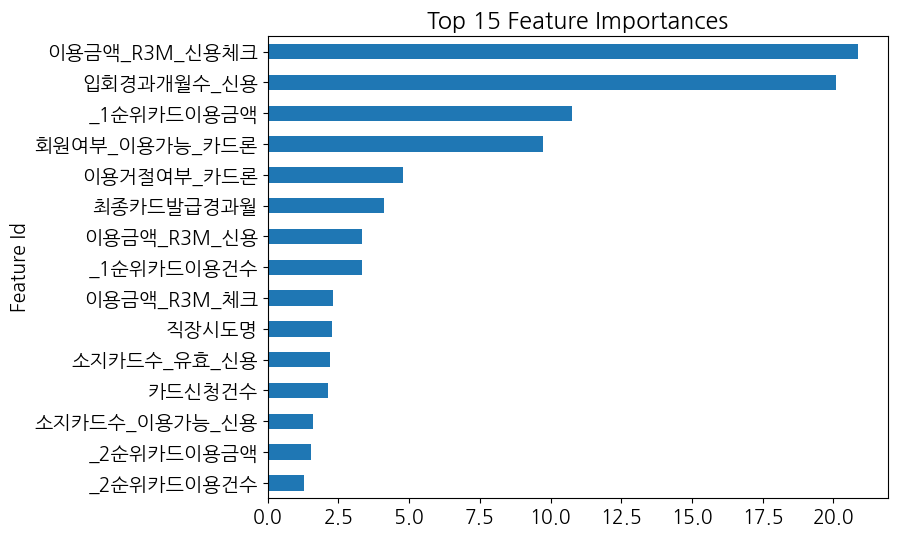

In [21]:
import matplotlib.pyplot as plt

# 상위 15개 시각화
top_n = 15
feature_importances[:top_n].plot(
    kind='barh',
    x='Feature Id',
    y='Importances',
    figsize=(8, 6),
    legend=False
)
plt.title(f"Top {top_n} Feature Importances")
plt.gca().invert_yaxis()
plt.show()

- **select features**
  - 계산된 중요도를 기반으로 가장 중요한 특성들을 선택하는 방법 결정
  - ex) 중요도 상위 N개, 특정 임계값 이상의 중요도를 가진 특성



In [23]:
# 상위 15개 피처
top_n = 15
selected_features = feature_importances['Feature Id'][:top_n].tolist()

print("선택된 피처 수:", len(selected_features))
print("선택된 피처 이름:", selected_features)

선택된 피처 수: 15
선택된 피처 이름: ['이용금액_R3M_신용체크', '입회경과개월수_신용', '_1순위카드이용금액', '회원여부_이용가능_카드론', '이용거절여부_카드론', '최종카드발급경과월', '이용금액_R3M_신용', '_1순위카드이용건수', '이용금액_R3M_체크', '직장시도명', '소지카드수_유효_신용', '카드신청건수', '소지카드수_이용가능_신용', '_2순위카드이용금액', '_2순위카드이용건수']


- data store
  - train

In [11]:
# train_회원_imp.parquet저장
import pandas as pd
train = pd.read_parquet('/content/drive/MyDrive/final_project/train_회원정보_인코딩.parquet')

# 'ID' 컬럼과 selected_features에 포함된 컬럼들만 선택
columns_to_select = ['ID'] + selected_features
train_selected_with_id = train[columns_to_select]

train_selected_with_id

,ID,이용금액_R3M_신용체크,입회경과개월수_신용,_1순위카드이용금액,회원여부_이용가능_카드론,이용거절여부_카드론,최종카드발급경과월,이용금액_R3M_신용,_1순위카드이용건수,이용금액_R3M_체크,직장시도명,소지카드수_유효_신용,카드신청건수,소지카드수_이용가능_신용,_2순위카드이용금액,_2순위카드이용건수
0,TRAIN_000000,196,67,3681,0,0,22,196,26,0,9,1,0,1,0,0
1,TRAIN_000001,13475,12,13323,1,0,18,13475,46,0,1,1,0,1,0,0
2,TRAIN_000002,23988,124,24493,0,0,20,23988,28,0,9,1,0,1,0,0
3,TRAIN_000003,3904,27,5933,0,0,17,3904,1,0,8,2,1,2,0,0
4,TRAIN_000004,1190,2,0,1,0,15,0,-2,1190,4,1,1,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2399995,TRAIN_399995,10755,209,5640,1,0,39,7267,3,3488,11,1,0,1,0,0
2399996,TRAIN_399996,27636,17,26357,1,0,24,27636,38,0,12,1,0,1,0,0
2399997,TRAIN_399997,23187,115,17171,0,0,18,23187,33,0,9,1,0,1,0,0
2399998,TRAIN_399998,0,71,0,1,0,27,0,-2,0,8,1,0,1,0,0


In [12]:
train_selected_with_id.to_parquet('/content/drive/MyDrive/final_project/train_회원_sel.parquet')

- test

In [28]:
test = pd.read_parquet('/content/drive/MyDrive/final_project/test_회원정보.parquet')
columns_to_select = ['ID'] + selected_features
test_selected_with_id = test[columns_to_select]

In [9]:
test_selected_with_id

,ID,이용금액_R3M_신용체크,입회경과개월수_신용,_1순위카드이용금액,회원여부_이용가능_카드론,이용거절여부_카드론,최종카드발급경과월,이용금액_R3M_신용,_1순위카드이용건수,이용금액_R3M_체크,직장시도명,소지카드수_유효_신용,카드신청건수,소지카드수_이용가능_신용,_2순위카드이용금액,_2순위카드이용건수
0,TEST_00000,21458,51,13852,0,1,45,21458,51,0,1,2,0,2,6021,33
1,TEST_00001,18681,30,11065,0,0,19,10759,40,7921,4,1,0,1,0,0
2,TEST_00002,40758,5,27071,1,0,5,40758,154,0,1,2,0,2,10704,69
3,TEST_00003,5255,73,4827,1,0,7,5255,105,0,4,1,0,1,0,0
4,TEST_00004,16148,176,8011,1,0,1,14290,52,1857,1,1,0,1,6387,39
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
599995,TEST_99995,0,69,0,0,0,0,0,-2,0,13,0,0,0,0,0
599996,TEST_99996,3110,14,1231,1,0,12,3110,4,0,17,1,0,1,0,0
599997,TEST_99997,0,6,0,1,0,11,0,6,0,10,1,0,1,0,0
599998,TEST_99998,173263,82,63592,1,0,1,113786,185,59476,10,3,0,3,31916,125


In [10]:
# test도 불러와서 해당 컬럼들로만 저장
test_selected_with_id.to_parquet('/content/drive/MyDrive/final_project/test_회원_sel.parquet')